In [60]:
import yfinance as yf
import pandas as pd
import os

In [61]:
sp500 = yf.Ticker("^GSPC")

In [62]:
sp500 = sp500.history(period="max")

In [63]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-30 00:00:00-04:00,4422.439941,4458.479980,4422.439941,4450.379883,3923450000,0.0,0.0
2023-07-03 00:00:00-04:00,4450.479980,4456.459961,4442.290039,4455.589844,2034280000,0.0,0.0
2023-07-05 00:00:00-04:00,4442.040039,4454.060059,4436.609863,4446.819824,3482620000,0.0,0.0


In [64]:
del sp500['Dividends']
del sp500['Stock Splits']

In [65]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [66]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [67]:
sp500 = sp500.loc['1990-01-02':].copy()

In [92]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [101]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.5625

In [79]:
test["Target"].value_counts()

1    51
0    49
Name: Target, dtype: int64

<Axes: xlabel='Date'>

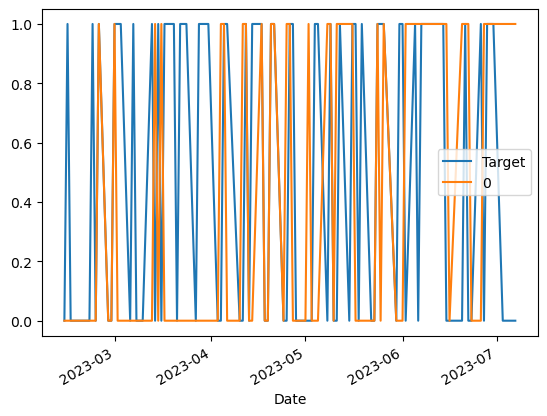

In [95]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [96]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [97]:
predict(train, test, predictors, model)

,Target,Predictions
Date,,
2023-02-13 00:00:00-05:00,0,0
2023-02-14 00:00:00-05:00,1,0
2023-02-15 00:00:00-05:00,0,0
2023-02-16 00:00:00-05:00,0,0
2023-02-17 00:00:00-05:00,0,0
...,...,...
2023-06-30 00:00:00-04:00,1,1
2023-07-03 00:00:00-04:00,0,1
2023-07-05 00:00:00-04:00,0,1


In [99]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

In [102]:
predictions = backtest(sp500, model, predictors)

In [104]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.533737
0    0.466263
Name: Target, dtype: float64

In [105]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5294117647058824

In [106]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

In [107]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])

In [108]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
1993-12-14 00:00:00-05:00,465.730011,466.119995,462.459991,463.059998,275050000,461.839996,0,0.997157,1.0,0.996617,1.0,1.000283,32.0,1.028047,127.0,1.176082,512.0
1993-12-15 00:00:00-05:00,463.059998,463.690002,461.839996,461.839996,331770000,463.339996,1,0.998681,0.0,0.995899,1.0,0.997329,32.0,1.025151,126.0,1.172676,512.0
1993-12-16 00:00:00-05:00,461.859985,463.980011,461.859985,463.339996,284620000,466.380005,1,1.001621,1.0,0.999495,2.0,1.000311,32.0,1.028274,127.0,1.176163,513.0
1993-12-17 00:00:00-05:00,463.339996,466.380005,463.339996,466.380005,363750000,465.850006,0,1.003270,2.0,1.004991,3.0,1.006561,32.0,1.034781,128.0,1.183537,514.0
1993-12-20 00:00:00-05:00,466.380005,466.899994,465.529999,465.850006,255900000,465.299988,0,0.999431,1.0,1.003784,2.0,1.005120,32.0,1.033359,128.0,1.181856,513.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 00:00:00-04:00,4422.439941,4458.479980,4422.439941,4450.379883,3923450000,4455.589844,1,1.006097,2.0,1.014636,3.0,1.057301,32.0,1.109962,119.0,1.173857,533.0
2023-07-03 00:00:00-04:00,4450.479980,4456.459961,4442.290039,4455.589844,2034280000,4446.819824,0,1.000585,2.0,1.009986,4.0,1.057010,33.0,1.110570,119.0,1.174785,533.0
2023-07-05 00:00:00-04:00,4442.040039,4454.060059,4436.609863,4446.819824,3482620000,4411.589844,0,0.999015,1.0,1.004882,3.0,1.053506,32.0,1.107719,118.0,1.172030,532.0


In [110]:
model = RandomForestClassifier(n_estimators=1000, min_samples_split=50, random_state=1)


In [111]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [112]:
predictions = backtest(sp500, model, new_predictors)

In [113]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5667539267015707

In [114]:
predictions["Target"].value_counts() / predictions.shape[0]

1    0.543597
0    0.456403
Name: Target, dtype: float64